In [ ]:
import pathlib, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import Sparta
from elyawy.constants import SUMSTATS_LIST, SUMSTATS_DEFINITION
from elyawy.io import load_sims_df

: 

In [2]:
# data fetching
res_path = pathlib.Path("/home/elyalab/Dev/projects/SpartaPipeline/scripts/small_test").resolve() # sys.argv[2]
full_data, regressors, regressors_stats = load_sims_df(res_path, correction=False)

for file_path in res_path.iterdir():
    if ".tree" in file_path.suffix:
        tree_file = file_path
    if ".fasta" in file_path.suffix:
        msa_file = file_path


simulator = Sparta.Sim(str(tree_file))
empirical_msa = Sparta.Msa(str(msa_file))
empirical_sum_stats = empirical_msa.get_sum_stats()

In [4]:
full_data

,root_length,length_param_insertion,length_param_deletion,insertion_rate,deletion_rate,SS_0,SS_1,SS_2,SS_3,SS_4,...,SS_19,SS_20,SS_21,SS_22,SS_23,SS_24,SS_25,SS_26,length_distribution,indel_model
0,102.0,0.021906,0.021906,1.666191,1.666191,1.380952,109.0,104.0,102.0,21.0,...,1.0,0.0,0.0,0.0,100.0,2.0,0.0,6.0,zipf,sim
1,100.0,0.043994,0.043994,1.772385,1.772385,1.272727,104.0,101.0,95.0,22.0,...,0.0,0.0,0.0,0.0,92.0,6.0,0.0,4.0,zipf,sim
2,122.0,0.045468,0.045468,1.781488,1.781488,1.0625,125.0,124.0,119.0,16.0,...,0.0,0.0,0.0,0.0,114.0,7.0,3.0,1.0,zipf,sim
3,90.0,0.021477,0.021477,1.997939,1.997939,1.214286,92.0,90.0,87.0,14.0,...,0.0,0.0,0.0,0.0,87.0,0.0,0.0,2.0,zipf,sim
4,116.0,0.019868,0.019868,1.729624,1.729624,10.857143,117.0,116.0,50.0,7.0,...,0.0,1.0,0.0,0.0,46.0,68.0,2.0,1.0,zipf,sim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,103.0,0.024986,0.02358,6.300232,11.361065,8.923077,126.0,112.0,93.0,13.0,...,0.0,2.0,0.0,2.0,80.0,22.0,1.0,23.0,poisson,rim
596,123.0,0.017005,0.025556,12.464806,3.098189,11.85,178.0,153.0,115.0,20.0,...,0.0,5.0,0.0,1.0,98.0,22.0,0.0,41.0,poisson,rim
597,85.0,0.031765,0.014805,4.633913,9.060648,5.714286,106.0,100.0,85.0,14.0,...,2.0,0.0,3.0,0.0,78.0,0.0,16.0,12.0,poisson,rim
598,97.0,0.038351,0.028694,17.627639,11.787105,19.4,114.0,114.0,68.0,5.0,...,0.0,1.0,0.0,1.0,68.0,29.0,0.0,17.0,poisson,rim


In [4]:
# cleanup and preprocess
data_types = {column:float  for column in full_data.columns}
data_types["length_distribution"] = str
data_types["indel_model"] = str
full_data = full_data.astype(data_types)

reorder_columns = [ 
                    "root_length",
                    "length_distribution",
                    "length_param_insertion",
                    "length_param_deletion",
                    "insertion_rate",
                    "deletion_rate",
                    "indel_model"
                  ]

In [17]:
# distances calculation:
true_msa_sum_stats = np.array(empirical_sum_stats)


# if regressors_stats is not None:
#     kept_stats_indices = regressors_stats[regressors_stats['pearsonr'] > 0.9].index
#     if len(kept_stats_indices) < 15:
#         kept_stats_indices = sorted(regressors_stats.nlargest(15, 'pearsonr').index)
#     SUB_SUMSTATS_LIST = [SUMSTATS_LIST[i] for i in kept_stats_indices]
#     true_msa_sum_stats = true_msa_sum_stats[kept_stats_indices]
simulated_sum_stats = full_data[SUMSTATS_LIST].astype(np.float32)


cov = np.cov(simulated_sum_stats.T)
inv_covmat = np.linalg.inv(cov)
u_minus_v = true_msa_sum_stats-simulated_sum_stats
left = np.dot(u_minus_v, inv_covmat)
mahalanobis_distances = np.sqrt(np.sum(u_minus_v*left, axis=1))

full_data["distances"] = mahalanobis_distances

In [22]:
length_distributions = ["geometric","poisson", "zipf"]
top_number = 50
num_sims_sample = 20000
# plt.figure(figsize=(10, np.sqrt(2)*10))
# plt.suptitle(f"adequacy distribution\n", size=24)

all_sims_data = pd.DataFrame()
for dist in length_distributions:

    top_sims = full_data[full_data["length_distribution"] == dist].nsmallest(top_number, "distances")

    params_top_sims = top_sims.loc[:,reorder_columns]
    params_top_sims["length_distribution"] = top_sims["length_distribution"]
    params_top_sims["indel_model"] = top_sims["indel_model"]

    params_top_sims = params_top_sims[reorder_columns]
    dist_samples = params_top_sims.sample(num_sims_sample, replace=True).reset_index(drop=True)

    def simulate_samples(params):
        refactored_params = copy.deepcopy(params.values)[:-1]
        refactored_params[0] = int(refactored_params[0])
        refactored_params[2] = [refactored_params[2]]
        refactored_params[3] = [refactored_params[3]]
        simulator.init_sim(*refactored_params)
        sim_msa = simulator.run_sim()
        sim_msa.calc_stats()
        temp_params = params.values.tolist()[:-1]
        temp_params = [temp_params[0]] + temp_params[2:]
        temp_params += sim_msa.get_sum_stats()
        temp_params = np.array(temp_params).reshape(1,-1)
        chosen_reg = f"{dist}_{params.values[-1]}"
        temp_params = np.array([regressor.predict(temp_params).T for regressor in regressors[chosen_reg]])
        return pd.Series(temp_params.reshape(-1).tolist(), SUMSTATS_LIST)
    sample_sum_stats = dist_samples.apply(simulate_samples, axis=1)
    sample_sum_stats["length_distribution"] = dist
    all_sims_data = pd.concat([all_sims_data, sample_sum_stats], axis=0)
all_sims_data = all_sims_data.reset_index(drop=True)

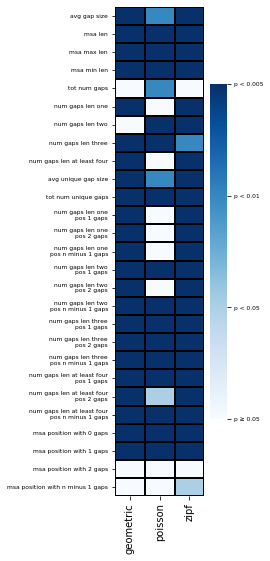

In [23]:
ranges_adequacy = [(2.5,97.5),(0.5,99.5),(0.25, 99.75)]
def check_interval(length_dist):
    rows_filter = all_sims_data['length_distribution'] == length_dist
    rows_to_check = all_sims_data[rows_filter]
    rows_to_check = rows_to_check[SUMSTATS_LIST]

    check_count = pd.Series(index=SUMSTATS_LIST, data=[0]*len(SUMSTATS_LIST),dtype=int)
    for left_lim, right_lim in ranges_adequacy:
        left_check = rows_to_check.quantile(left_lim/100) < empirical_sum_stats
        right_check = rows_to_check.quantile(right_lim/100) > empirical_sum_stats
        check_count = check_count + (left_check & right_check).astype(int)
    check_count.name = length_dist
    return check_count
adequacy_summary = pd.concat([check_interval(dist) for dist in length_distributions], axis=1)

adequacy_summary.index = [" ".join(stat_def.split('_')).lower() for stat_def in SUMSTATS_DEFINITION.values()]

fig = plt.figure(figsize = (2,9))

ax = sns.heatmap(adequacy_summary, cmap="Blues", linewidths=2, linecolor='black')
ax.set_yticklabels(ax.get_yticklabels(), size = 6)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(['p ≥ 0.05', 'p < 0.05', 'p < 0.01', 'p < 0.005'], size = 6)
plt.show()


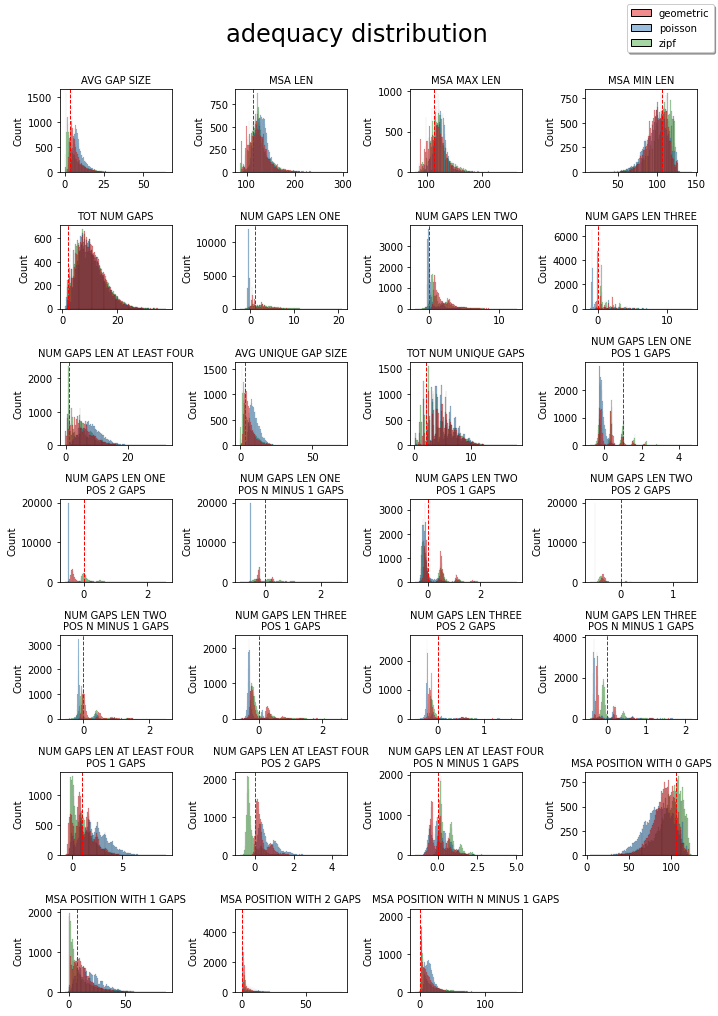

In [24]:
sns.set_palette("Set1", 3)
fig = plt.figure(figsize=(10, np.sqrt(2)*10))
plt.suptitle(f"adequacy distribution\n", size=24)
for current_stat in range(27):
    empirical_x = empirical_sum_stats[current_stat]

    x_min = all_sims_data[f"SS_{current_stat}"].min()
    x_max = all_sims_data[f"SS_{current_stat}"].max()
    x_min = x_min if x_min < empirical_x else empirical_x
    x_max = x_max if x_max > empirical_x else empirical_x
    x_offset =  5*np.abs(x_max-x_min)/100

    ax = plt.subplot(7,4, current_stat+1)
    sns.histplot(data=all_sims_data, 
                 x=f"SS_{current_stat}",
                 ax=ax,
                 hue="length_distribution",
                #  element="step",
                #  fill=False,
                 legend = False if current_stat < 26 else True)
    plt.xlabel('')
    plt.title(" ".join(SUMSTATS_DEFINITION[f"SS_{current_stat}"].split("_")), size=10)

    plt.axvline(x=empirical_sum_stats[current_stat], linewidth=1, color='r', linestyle='--')
    plt.xlim(x_min-x_offset, x_max+x_offset)


legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
fig.legend(handles, length_distributions, loc='upper right', fontsize=10, shadow=True)

plt.tight_layout()
# plt.savefig(join_path(f"adequacy.png"), dpi=300)
# plt.close()
plt.show()

In [25]:
adequacy_summary
p_vals = [1, 0.05, 0.01, 0.005]
def convert_to_pvals(x):
    return x.apply(lambda y: p_vals[y])

p_val_summary = adequacy_summary.apply(convert_to_pvals, axis=1)
p_val_summary.sum()

geometric    4.115
poisson      8.155
zipf         2.175
dtype: float64